In [5]:
import numpy as np
import networkx as nx
from sklearn.cluster import SpectralClustering
from torch_geometric.datasets import GNNBenchmarkDataset
from torch_geometric.utils import to_dense_adj
from torch_geometric.utils import to_networkx, from_networkx

In [3]:
dataset = GNNBenchmarkDataset(root='tmp/gnn_benchmark', name='CSL')

print(f'Dataset: {dataset}:')
print('======================')
print(f'Number of graphs: {len(dataset)}')
print(f'Number of features: {dataset.num_features}')
print(f'Number of classes: {dataset.num_classes}')

data = dataset[0]
print(data)

Dataset: CSL(150):
Number of graphs: 150
Number of features: 0
Number of classes: 10
Data(edge_index=[2, 164], y=[1], num_nodes=41)


In [9]:
import torch_geometric
import copy
from typing import List, Tuple
from torch_geometric.data import Batch, Data
from torch_geometric.data.collate import collate
from torch_geometric.data.data import BaseData
from torch_geometric.data.dataset import Dataset, IndexType
from torch_geometric.data.separate import separate
from torch_geometric.io import fs
from torch import from_numpy, mean, svd, lt, diag, t
import torch
from tqdm import tqdm

class GMixupDataset():
    r"""A wrapper class around a dataset that applies G-Mixup data augmentation to its base dataset.

    Args:
        base_dataset (Dataset): The dataset to apply G-Mixup to.
        log (bool, optional): Whether to print any console output while processing the dataset. (default: :obj:`True`)
        align_graphs (bool, optional): Whether to align the graphs by node degree before generating graphons. (default: :obj:`True`)
        threshold (float, optional): The threshold to use for singular value thresholding. (default: :obj:`1.02`)
        generate_graphons (bool, optional): Whether to generate graphons for the dataset during initialization or on-the-fly. (default: :obj:`True`) Note that generating graphons for the dataset during initialization can be slow for large datasets. (default: :obj:`True`)
    """

    def __init__(
        self,
        base_dataset: Dataset,
        log: bool = True,
        align_graphs: bool = True,
        threshold: float = 1.02,
        generate_graphons: bool = True,
    ) -> None:
        self.base_dataset = base_dataset
        self.log = log
        self.align_graphs = align_graphs
        self.threshold = threshold
        
        self.graphs_by_class = [np.empty(0, dtype=int) for _ in range(self.base_dataset.num_classes)]
        for i, data in enumerate(self.base_dataset):
            label = data.y.item()
            self.graphs_by_class[label] = np.append(self.graphs_by_class[label], i)
            
        self.max_node_count = int(np.max([data.num_nodes for data in self.base_dataset]))
        self.graphons = np.zeros((self.base_dataset.num_classes, self.max_node_count, self.max_node_count))
        self.graphons_generated = torch.zeros(self.base_dataset.num_classes, dtype=torch.bool)
        
        if generate_graphons:
            self.generate_graphons()
        else:
            if self.log:
                print(f"Graphons not generated during initialization. Graphons will be generated on-the-fly, or you can call generate_graphons() to generate them all at once.\n")
        
    def generate_graphons(self) -> None:
        if self.log:
            print(f"Generating graphons for {self.base_dataset.num_classes} classes...\n")
        
        for i in range(self.base_dataset.num_classes):
            if self.graphons_generated[i]:
                if self.log:
                    print(f"Graphon for class {i} already generated, skipping...")
                continue
            else:
                self.generate_graphon(i)
        
        return None
    
    def align_graphs_by_degree(self, graph_adjs:List[np.ndarray]) -> Tuple[List[np.ndarray], List[np.ndarray], int, int] :
        num_nodes = [graph_adj.shape[0] for graph_adj in graph_adjs]
        max_num = max(num_nodes)
        min_num = min(num_nodes)

        aligned_adjs = []
        normalized_node_degrees = []
        for graph_adj in graph_adjs :
            curr_n = graph_adj.shape[0]
            node_degree = 0.5 * np.sum(graph_adj, axis=0) + 0.5 * np.sum(graph_adj, axis=1)
            node_degree /= np.sum(node_degree)
            perm = np.argsort(node_degree)  # ascending
            perm = perm[::-1]  # descending

            sorted_node_degree = node_degree[perm]
            sorted_node_degree = sorted_node_degree.reshape(-1, 1)

            sorted_graph = copy.deepcopy(graph_adj)
            sorted_graph = sorted_graph[perm, :]
            sorted_graph = sorted_graph[:, perm]

            normalized_node_degree = np.zeros((max_num, 1))
            normalized_node_degree[:curr_n, :] = sorted_node_degree
            aligned_adj = np.zeros((max_num, max_num))
            aligned_adj[:curr_n, :curr_n] = sorted_graph
            normalized_node_degrees.append(normalized_node_degree)
            aligned_adjs.append(aligned_adj)
        return aligned_adjs, normalized_node_degrees, max_num, min_num

    def generate_graphon(self, class_idx: int) -> np.ndarray :
        if self.graphons_generated[class_idx]:
            if self.log:
                print(f"Graphon for class {class_idx} already generated, skipping...")
            return self.graphons[class_idx]
        
        class_adj_mats = [nx.to_numpy_array(to_networkx(self.base_dataset[graph_index])) 
                          for graph_index in self.graphs_by_class[class_idx]]
        
        if self.align_graphs:
            aligned_graphs, normalized_node_degrees, max_num, min_num = self.align_graphs_by_degree(class_adj_mats)
            class_adj_mats = aligned_graphs
        
        graph_tensor_np = np.array(class_adj_mats)
        graph_tensor = from_numpy(graph_tensor_np).float()
        
        if self.log:
            print(f"Generating graphon for class {class_idx} with {graph_tensor.size(0)} graphs...")
        
        # TODO: i believe this breaks when each graph has different number of nodes
        # we could potentially offer this as a speedup option to the user if we pad the adjacency matrices        
        # # collapse adj mats into 1 matrix
        # if graph_tensor.size(0) > 1 :
        #     agg_graph_adj = mean(graph_tensor, dim=0)
        # else :
        #     agg_graph_adj = graph_tensor[0, :, :]
        
        graphons = None
        for agg_graph_adj in tqdm(graph_tensor):
            # normalize adjacency matrix to be in interval [-1, 1]
            agg_graph_adj_normalized = 2 * agg_graph_adj - 1
            
            # svd graphon estimation \cite{Chatterjee}
            U, S, Vh = torch.linalg.svd(agg_graph_adj_normalized)
            
            num_nodes = agg_graph_adj.size(0)
            num_edges = torch.sum(agg_graph_adj == 1)
            proportion_edges = num_edges / (num_nodes ** 2) / 2
            
            scaled_thresh = self.threshold * ((num_nodes * proportion_edges) ** 0.5)
            S[lt(S, scaled_thresh)] = 0
            
            graphon = U @ diag(S) @ Vh
            
            graphon[graphon >= 1] = 1 # clip
            graphon[graphon <= -1] = -1 # clip
            graphon = (graphon + 1) / 2 # renormalize graphon to be in interval [0, 1]
            graphon = torch.nn.functional.interpolate(graphon.unsqueeze(0).unsqueeze(0), size=(self.max_node_count, self.max_node_count), mode='bilinear', align_corners=False).squeeze()
            
            if graphons is None:
                graphons = graphon
            else:
                graphons = torch.cat((graphons, graphon), dim=0)
        
        final_graphon = torch.mean(graphons, dim=0)
        self.graphons[class_idx] = final_graphon.numpy()
        self.graphons_generated[class_idx] = True
        
        if self.log:
            print(f"Graphon for class {class_idx} generated.")
            print(f"graphon avg = {torch.mean(final_graphon)}, original avg = {torch.mean(graph_tensor)}. These should be close.\n")
        
        return graphon.numpy()
  
    # TODO: check how IndexType works in torch_geometric    
    def generate_graphs(self, idx_1: int, idx_2: int, mixing_param: float = 0.5, K: int = 10, method: str = 'random', size: int = 1) -> Batch:
        # ) -> 'Dataset':
        r"""Takes in a batch of graph label pairs and a mixing parameter λ, and returns the new synthetic graph(s) generated using G-Mixup
        
        Args:
            idx_1 (int): Index of the first graph in the pair
            idx_2 (int): Index of the second graph in the pair
            mixing_param (float): The mixing parameter λ
            K (int): The number of nodes in the output synthetic graph(s)
            method (str): The method to use for generating the synthetic graph(s). Options are 'random' and 'uniform'. (default: :obj:`'random'`)
            size (int): The number of synthetic graphs to generate. (default: :obj:`1`)
        """
        if not self.graphons_generated[idx_1]:
            if self.log:
                print(f"Graphon for class {idx_1} not yet generated, generating...")
            self.generate_graphon(idx_1)
        if not self.graphons_generated[idx_2]:
            if self.log:
                print(f"Graphon for class {idx_2} not yet generated, generating...")
            self.generate_graphon(idx_2)
        
        if self.log:
            print(f"Generating {size} synthetic graph(s) for indices {idx_1} and {idx_2} with mixing parameter {mixing_param} and {K} nodes...")
        
        graphs = None
        for i in range(size):
            graph = self.generate_graph(idx_1, idx_2, mixing_param, K, method)
            if i == 0:
                graphs = graph
            else:
                graphs = torch.cat((graphs, graph), dim=0)
        
        return graphs
                
    def generate_graph(self, idx_1: int, idx_2: int, mixing_param: float = 0.5, K: int = 10, method: str = 'random') -> Data:
        graphon1 = self.graphons[idx_1]
        graphon2 = self.graphons[idx_2]
        mixed_graphon = mixing_param * graphon1 + (1 - mixing_param) * graphon2
        
        u_values = None
        u_values_index = None
        if method == 'random':
            u_values = np.random.uniform(0, 1, K)
            u_values.sort()
            u_values_index = (u_values * mixed_graphon.shape[0]).astype(int)
        elif method == 'uniform':
            u_values = np.linspace(0, 1, K) # DEBUGGING: use this to reconstruct without RNG, should reconstruct nearly the same graph if there is no thresholding
            u_values_index = (u_values * mixed_graphon.shape[0]).astype(int)
        else:
            raise ValueError('Invalid method')
                    
        adjacency_matrix = np.zeros((K, K))
        for i in range(K):
            for j in range(K):
                p = mixed_graphon[u_values_index[i], u_values_index[j]]
                if np.random.rand() < p:
                    adjacency_matrix[i, j] = 1
                    # adjacency_matrix[j, i] = 1
                
        # graph = nx.from_numpy_array(adjacency_matrix)
        graph = nx.from_numpy_array(adjacency_matrix, create_using=nx.DiGraph)
        graph_pyg = from_networkx(graph)
        
        if self.log:
            print(f"Synthetic graph(s) generated.\n")
        
        return graph_pyg
    
    def __getattr__(self, name: str):
        if name in self.__dict__:
            return getattr(self, name)
        else:
            return getattr(self.base_dataset, name)

In [10]:
gnn_benchmark = GNNBenchmarkDataset(root='tmp/gnn_benchmark', name='CSL')
gmixup_gnn_benchmark = GMixupDataset(gnn_benchmark)

Generating graphons for 10 classes...

Generating graphon for class 0 with 15 graphs...


100%|██████████| 15/15 [00:00<00:00, 597.49it/s]


Graphon for class 0 generated.
graphon avg = 0.10685962438583374, original avg = 0.09756097197532654. These should be close.

Generating graphon for class 1 with 15 graphs...


100%|██████████| 15/15 [00:00<00:00, 2543.24it/s]


Graphon for class 1 generated.
graphon avg = 0.11127594858407974, original avg = 0.09756097197532654. These should be close.

Generating graphon for class 2 with 15 graphs...


100%|██████████| 15/15 [00:00<00:00, 3394.37it/s]


Graphon for class 2 generated.
graphon avg = 0.10681840777397156, original avg = 0.09756097197532654. These should be close.

Generating graphon for class 3 with 15 graphs...


100%|██████████| 15/15 [00:00<00:00, 3701.51it/s]


Graphon for class 3 generated.
graphon avg = 0.10874942690134048, original avg = 0.09756097197532654. These should be close.

Generating graphon for class 4 with 15 graphs...


100%|██████████| 15/15 [00:00<00:00, 3365.49it/s]


Graphon for class 4 generated.
graphon avg = 0.10846292972564697, original avg = 0.09756097197532654. These should be close.

Generating graphon for class 5 with 15 graphs...


100%|██████████| 15/15 [00:00<00:00, 3393.82it/s]


Graphon for class 5 generated.
graphon avg = 0.11272729188203812, original avg = 0.09756097197532654. These should be close.

Generating graphon for class 6 with 15 graphs...


100%|██████████| 15/15 [00:00<00:00, 3201.76it/s]


Graphon for class 6 generated.
graphon avg = 0.10874319076538086, original avg = 0.09756097197532654. These should be close.

Generating graphon for class 7 with 15 graphs...


100%|██████████| 15/15 [00:00<00:00, 3667.42it/s]


Graphon for class 7 generated.
graphon avg = 0.10436788201332092, original avg = 0.09756097197532654. These should be close.

Generating graphon for class 8 with 15 graphs...


100%|██████████| 15/15 [00:00<00:00, 3549.48it/s]


Graphon for class 8 generated.
graphon avg = 0.10855419933795929, original avg = 0.09756097197532654. These should be close.

Generating graphon for class 9 with 15 graphs...


100%|██████████| 15/15 [00:00<00:00, 3807.93it/s]

Graphon for class 9 generated.
graphon avg = 0.10409849137067795, original avg = 0.09756097197532654. These should be close.



Generating 1 synthetic graph(s) for indices 0 and 0 with mixing parameter 0 and 41 nodes...
Synthetic graph(s) generated.

DiGraph with 41 nodes and 164 edges
graph real average degree:  4.0
Drawing Real Label 0 graph...
DiGraph with 41 nodes and 168 edges
graph gen average degree:  4.097560975609756
Drawing Generated Label 0 graph...


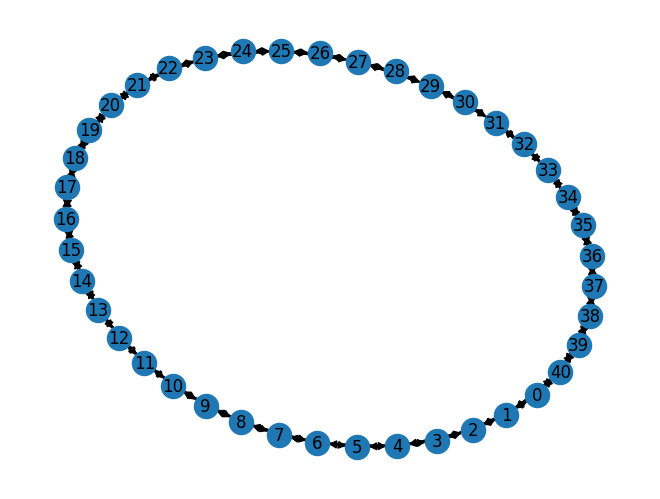

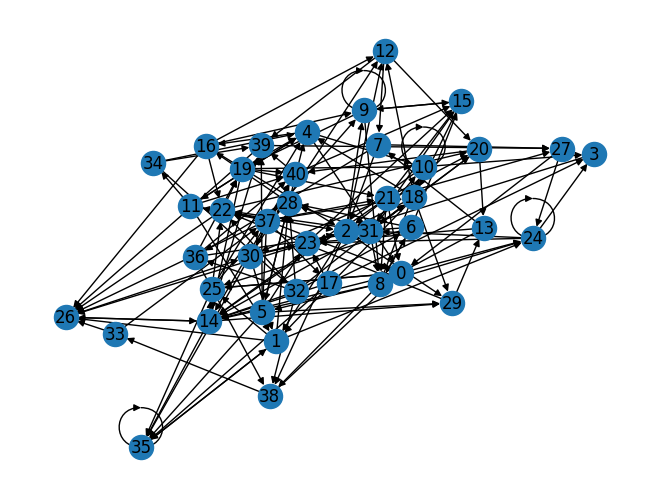

In [8]:
graph_real = to_networkx(gmixup_gnn_benchmark.base_dataset[gmixup_gnn_benchmark.graphs_by_class[0][0]])
graph_gen = to_networkx(gmixup_gnn_benchmark.generate_graphs(0, 0, 0, K=41))
# graph_gen = gmixup_gnn_benchmark.generate_graphs(0, 1, 1)


import matplotlib.pyplot as plt
print(graph_real)
print("graph real average degree: ", np.mean(list(dict(graph_real.degree()).values()))/2)
print("Drawing Real Label 0 graph...")
plt.figure(1)
nx.draw(graph_real, with_labels=True)
plt.figure(2)
print(graph_gen)
print("graph gen average degree: ", np.mean(list(dict(graph_gen.degree()).values()))/2)
print("Drawing Generated Label 0 graph...")
nx.draw(graph_gen, with_labels=True)

In [4]:
mnist = torch_geometric.datasets.MNISTSuperpixels(root="tmp/mnist")


In [104]:
gmixup_mnist = GMixupDataset(mnist, log=True, generate_graphons=False)

Graphons not generated during initialization. Graphons will be generated on-the-fly, or you can call generate_graphons() to generate them all at once.



In [105]:
gmixup_mnist.graphs_by_class[0]

array([    1,    21,    34, ..., 59952, 59972, 59987])

Graphon for class 0 not yet generated, generating...
Generating graphon for class 0 with 5923 graphs...
Graphon for class 0 generated.
graphon avg = 0.24900084733963013, original avg = 0.2368256002664566. These should be close.

Generating 1 synthetic graph(s) for indices 0 and 0 with mixing parameter 0 and 75 nodes...
Synthetic graph(s) generated.

DiGraph with 75 nodes and 1260 edges
graph real average degree:  33.6
Drawing Real Label 0 graph...
DiGraph with 75 nodes and 1384 edges
graph gen average degree:  36.906666666666666
Drawing Generated Label 0 graph...


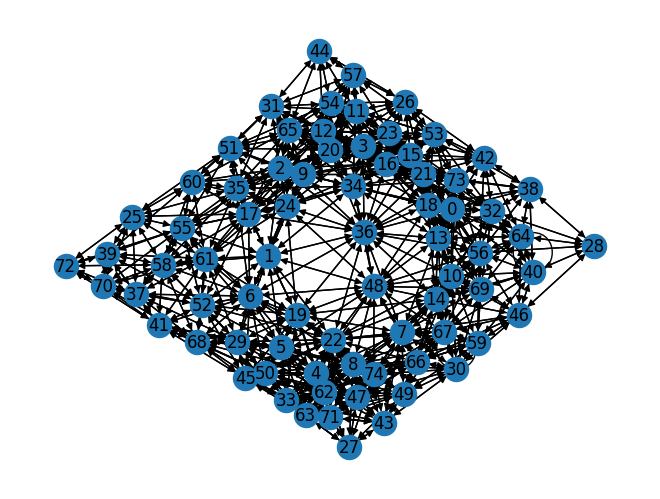

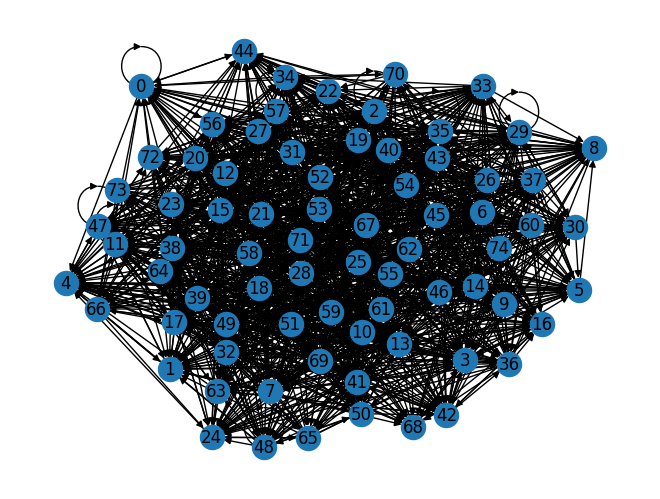

In [106]:
graph_real = to_networkx(gmixup_mnist.base_dataset[gmixup_mnist.graphs_by_class[0][0]])
graph_gen = gmixup_mnist.generate_graphs(0, 0, 0, K=75)

import matplotlib.pyplot as plt
print(graph_real)
print("graph real average degree: ", np.mean(list(dict(graph_real.degree()).values())))
print("Drawing Real Label 0 graph...")
plt.figure(1)
nx.draw(graph_real, with_labels=True)
plt.figure(2)
print(graph_gen)
print("graph gen average degree: ", np.mean(list(dict(graph_gen.degree()).values())))
print("Drawing Generated Label 0 graph...")
nx.draw(graph_gen, with_labels=True)